In [3]:
from imutils.contours import sort_contours
import numpy as np
import cv2
import sys
import imutils
import matplotlib.pyplot as plt

(-0.5, 2364.5, 1099.5, -0.5)

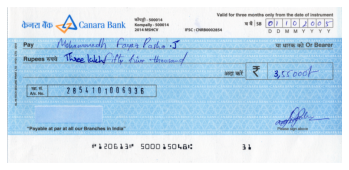

In [5]:
img = cv2.imread('upload_images/Cheque120613.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 2364.5, 1099.5, -0.5)

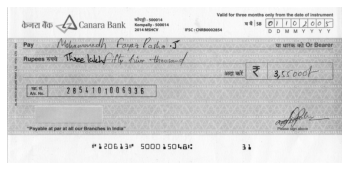

In [6]:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [7]:
# Initialize a rect and sqr kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25,7))
sqrKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21,21))

(-0.5, 2364.5, 1099.5, -0.5)

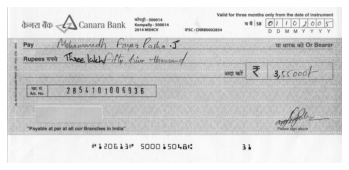

In [8]:
# Apply Gaussian Bluring
blur = cv2.GaussianBlur(gray, (3,3), 0)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 2364.5, 1099.5, -0.5)

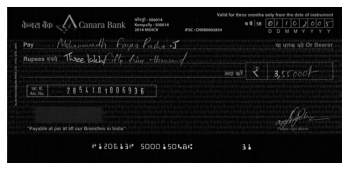

In [9]:
# Apply Blackhat Morph Operation to find dark regions on a light background
blackhat = cv2.morphologyEx(blur, cv2.MORPH_BLACKHAT, rectKernel)
plt.imshow(cv2.cvtColor(blackhat, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 2364.5, 1099.5, -0.5)

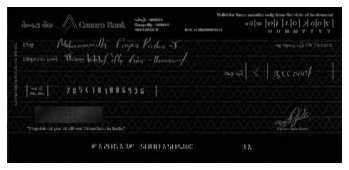

In [10]:
# Compute the Scharr gradient of the blackhat image revealing regions of the image that are dark against a light background
# and scale the result into the range [0, 255]
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
plt.imshow(cv2.cvtColor(grad, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 2364.5, 1099.5, -0.5)

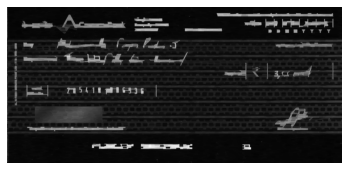

In [11]:
# Apply closing operation to close gaps between letters
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
plt.imshow(cv2.cvtColor(grad, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 2364.5, 1099.5, -0.5)

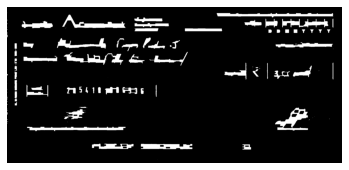

In [12]:
# Apply Otsu's threshold
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 2364.5, 1099.5, -0.5)

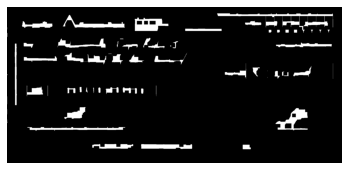

In [13]:
# Apply another closing operation and erosion to break apart connected components
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqrKernel)
thresh = cv2.erode(thresh, None, iterations=2)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [14]:
# Find contours and sort them accordingly
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

cnts = sort_contours(cnts, method='right-to-left')[0]

In [15]:
rois = []

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    roi = (x, y, w, h)
    rois.append(roi)

In [16]:
for idx, roi in enumerate(rois):
    (x, y, w, h) = rois[idx]
    pX = int((x + w) * 0.03)
    pY = int((y + h) * 0.03)
    (x, y) = (x - pX, y - pY)
    (w, h) = (w + (pX * 2), h + (pY * 2))

    # Extract the padded MRZ from the image
    image = img[y:y + h, x:x + w]

    # Convert image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Resize the image to be ten times the original size for better readability
    gray_img = cv2.resize(gray_img, (0,0), fx = 10, fy = 10, interpolation = cv2.INTER_CUBIC)
    
    # Perform Gaussian Blur to smoothen image
    blur = cv2.GaussianBlur(gray_img, (5,5), 0)
    
    # Use Otsu's thresholding to turn write up white and background black
    ret, thresh = cv2.threshold(gray_img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    
    # Use bitwise to flip image to black and background to white which is better for tesseract
    thresh = cv2.bitwise_not(thresh)

    # Save the Region of Interest (roi)
    cv2.imwrite('black/roi_' + str(idx) + '.jpg', thresh)

# Similarity

In [51]:
import cv2
from skimage.metrics import structural_similarity as ssim

In [52]:
def match(path1, path2):
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    
    # Turn images to graysccale
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # resize images for comparison
    img1 = cv2.resize(img1, (300, 300))
    img2 = cv2.resize(img2, (300, 300))
    
    # Check similarity
    similarity_value = "{:.2f}".format(ssim(img1, img2)*100)
    
    return float(similarity_value)

In [54]:
threshold = 85.00
result = match('black/roi_14.jpg', 'signature_database/roi_54.jpg')

if result > threshold:
    print('Real Signature(' + str(result) + ')')
    
else:
    print('Not Real(' + str(result) + ')')

Not Real(57.19)
